In [18]:
"""
This is a template for ML workflows
"""

summary of this file


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
import psycopg2
import json
import pickle


In [5]:
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin #gives fit_transform method for free
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor


> #### collect data and preprocessing

In [7]:
"""
part 1: collect raw data using SQL
"""
#### now this is entire 3 years' data (BETWEEN '2016-01-01'  AND '2018-12-31')

"""
# > ** part 1. connect to redshift and SQL data **
#     - connect to redshift
#     - process sql and get selected data to dataframe
"""


path_json = "/Users/xduan/Documents/work/learning/setup/redshift_creds.json.nogit"
with open(path_json) as fh:
    creds = json.load(fh)

HOST = creds['host_name']
PORT = creds['port_num']
USER =  creds['user_name']
PASSWORD = creds['password']
DATABASE = creds['db_name']

# print("Getting subscription info")
conn = psycopg2.connect(
  host=HOST,
  port=PORT,
  user=USER,
  password=PASSWORD,
  database=DATABASE,
  )

query = """
SELECT *
FROM adhoc.subs_monthly_lifetime
"""

try:
    raw_data = pd.read_sql(query, conn)
finally:
    conn.close()
    


In [8]:
"""
part 2.preprocessing data
    - get month data as a feature
    - parse grouping to multiply columns
"""
# convert to date format
raw_data['start_date'] = pd.to_datetime(raw_data['start_date'])

# get year
raw_data['year'] = raw_data['start_date'].dt.year
#get month
raw_data['month'] = raw_data['start_date'].dt.month

# split grouping
new = raw_data['grouping'].str.split('-', n = -1, expand = True)
raw_data['partner'],raw_data['geo'],raw_data['channel'],raw_data['primary_optin_listen'], raw_data['optin_source'],raw_data['account'] = new[0], new[1], new[2], new[3], new[5], new[6]
raw_data.shape

(13443, 5)

- choose appropriate dataset for training as data: set a threshold on initial cohort size

In [10]:
cohort_threshold = 100
filter_index = raw_data['initial_cohort_size'] > cohort_threshold
data = raw_data[filter_index]


In [11]:
data.shape

(2205, 13)

> ### part 2  feature engineering
   - selected features: 
   ['month','partner','geo','channel','primary_optin_listen','year','optin_source','account','price']

In [12]:
data['month_str'] = data['month'].apply(lambda row: 'month_'+ str(row))
data['year_str'] = data['year'].apply(lambda row: 'year_'+ str(row))

# get categorical features
category_lst = ['month_str','partner','geo','channel','primary_optin_listen','year_str','optin_source','account']
# numerical features
num_feature_lst = ['price']
# combine them to have final column list
column_lst = category_lst + num_feature_lst
# get X and y
X = data[column_lst]
y = data['lifetime']


# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)



"""
Data summary
- X: filtered based on initial cohort_size
- y: MONTHLY lifetime for each cohort

"""

> ### part 3. regression on monthly lifetime
    - random forest

In [13]:
"""
get columns names after one-hot-encoding
this is to use for plotting feature importance
"""

ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
X_dummy_category = ohe.fit_transform(X_train[category_lst])
# dummy category column list
dummy_column_lst = X_dummy_category.columns.tolist() # features

# dummy + numerical columns
final_column_lst = dummy_column_lst + num_feature_lst


In [15]:
# Import the necessary modules


"""
Random Forest
"""

start = time()
"""
ColumnTransformer
"""

# numeric feature pipeline
num_steps = [('scaler', StandardScaler())]
num_pipe = Pipeline(num_steps)

# categorical feature pipeline
#     cat_steps = [('LBL', MultiColumnLabelEncoder())]
cat_steps = [('ohe', ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True))
            ,('scaler', StandardScaler())]
cat_pipe = Pipeline(cat_steps)

# use ColumnTransformer do transformation separately
transformers = [('cat', cat_pipe, category_lst),
                ('num', num_pipe, num_feature_lst)] # change this list
ct = ColumnTransformer(transformers=transformers)


"""
final pipeline: ohe+ classifier with manual weight
"""

# set up final steps
steps = [('transform', ct),
         ('rf', RandomForestRegressor())]
# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rf__random_state': [1234]
              ,'rf__n_estimators':[200, 500]
              ,'rf__max_features':['auto','sqrt']}

gm_cv = GridSearchCV(pipeline, param_grid= parameters, cv = 5)

# Fit to the training set
gm_cv.fit(X_train, y_train)

"""
evaluation on test dataset
"""
# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
y_pred = gm_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned random forest: {}".format(gm_cv.best_params_))
print("Tuned R squared: {}".format(r2))
print("Tuned MSE: {}".format(mse))

print("this takes %.2f seconds" %(time()-start))


Tuned random forest: {'rf__n_estimators': 500, 'rf__max_features': 'sqrt', 'rf__random_state': 1234}
Tuned R squared: 0.800343269668
Tuned MSE: 0.745392459488
this takes 38.32 seconds


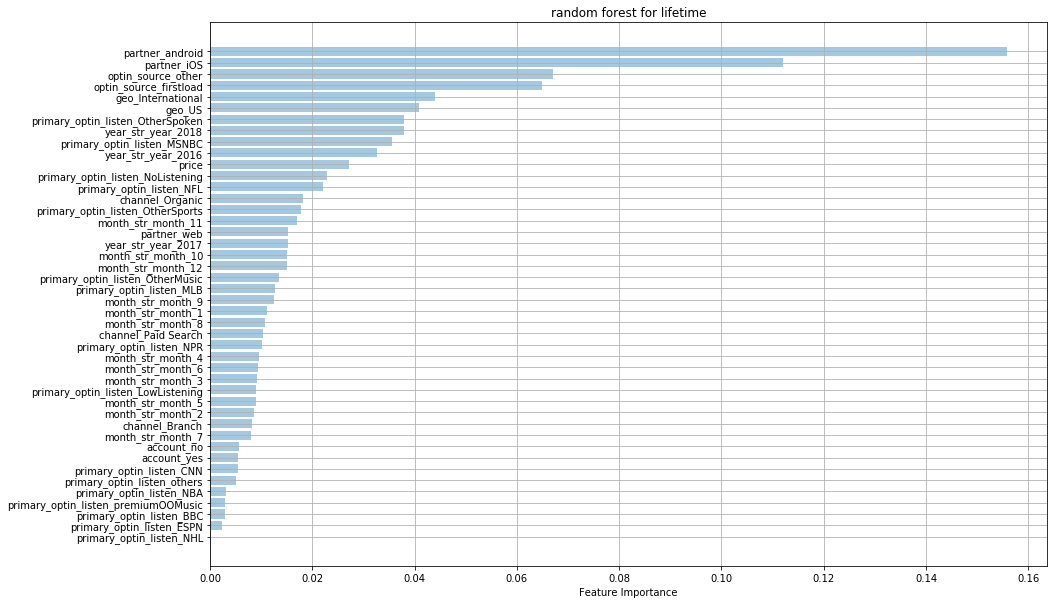

In [16]:
"""
This part is optional
This is to plot feature importance in Random Forest.

"""
# function to plot feature_importance or coefficients
def plot_feature_importance(feature_importances,feature_names, title):
    ftr_imp_df = pd.DataFrame(sorted(zip(feature_names,feature_importances)
                          , key=lambda x: x[1], reverse = False)
                   )
    y_pos = np.arange(ftr_imp_df.shape[0])

    plt.barh(y_pos, ftr_imp_df[1], align='center', alpha=0.4)
    plt.yticks(y_pos, ftr_imp_df[0])
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.grid()
    plt.show()
    
plt.subplots(figsize=(15,10))    
rf = gm_cv.best_estimator_.named_steps['rf']
feature_importances = rf.feature_importances_
feature_names = final_column_lst ## it is final_column_lst + direction sign from Ridge


plot_feature_importance(feature_importances,feature_names, title = 'random forest for lifetime')



In [17]:
"""
Save trained model using pickle, so we can use this trained model for future prediction.

"""

pipe = gm_cv.best_estimator_

path = '/Users/xduan/Desktop'
dump_path = path + '/pipe.pkl'

with open(dump_path, 'wb') as p:
    pickle.dump(pipe, p)

# 2.Load it again from  le:
with open('model.pkl', 'rb') as file:
    clf2 = pickle.load(file)

> ### other good pipeline flows

- Customizing your pipeline with your own scorer

In [ ]:
from sklearn.metrics import roc_auc_score, make_scorer
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(pipe, param_grid=params, scoring=auc_scorer)

In [ ]:
- workflow using FunctionTransformer to get self-defined module

In [ ]:
"""
case 3: use FunctionTransformer

- copy data instead of directly working on it
- treat data as numpy array inside function
"""

# def negate_second_column(X):
#     Z = X.copy()
#     Z[:,1] = -Z[:,1] 
#     return Z

# pipe = Pipeline([
#                 ('ft', FunctionTransformer(negate_second_column))
#                  , ('clf', RandomForestClassifier())
#                 ]
#                )

# Define a feature extractor to flag very large values
def more_than_average(X, multiplier=1.0):
    Z = X.copy()
    Z[:,1] = Z[:,1] > multiplier*np.mean(Z[:,1])
    return Z

# Convert your function so that it can be used in a pipeline
pipe = Pipeline([
  ('ft', FunctionTransformer(more_than_average)),
  ('clf', RandomForestClassifier(random_state=2))])

# Optimize the parameter multiplier using GridSearchCV
params = {'ft__multiplier': [1, 2, 3]}
gs = GridSearchCV(pipe, param_grid=params)
gs = gs.fit(X_train, y_train)

with open('pipe.pkl', 'wb') as file: 
    pickle.dump(gs, file)

    
# 2.Production environment:
with open('pipe.pkl', 'rb') as file:
    gs = pickle.dump(gs, file)

gs.predict(X_test)